In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score,\
                            recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

from category_encoders import OneHotEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# 1. Meet the Data

**Random unique Identifiers:**
`PassengerId` | `Ticket` : They have no impact on the outcome variable. So, they will be excluded.
--------------------------------------------
**Nominal Qualitiative Datatypes:**
1. `Name` : could be used in feature engineering to drive SES from titles such as doctor or master to see if things such as master makes a difference or not.

2. `Sex` : will be converted to dummy variables for maths calculations.

3. `Embarked` : will be converted to dummy variables. Each category (C, Q, S) will become a separate column.

4. `Cabin`: A partially available variable that represents the cabin number. As it has many null values, it will be excluded, otherwise it could be used for feature engineering for approximate position on ship.
--------------------------------------------
**Ordinal Qualitiative Datatypes:**
1. `Pclass` : representing the class of the ticket (1st (upper class), 2nd (middle class), 3rd class (lower class)), 
--------------------------------------------
**Continuous Quantitative Datatypes:**
1. `Age` : The age of each passenger in years.
2. `Fare` : The amount each passenger paid for their ticket.
--------------------------------------------
**Discrete Quantitative Datatypes:**
1. `SibSp`: Number of siblings or spouses aboard.

2. `Parch`: Number of parents or children aboard. Similar to SibSp, it is treated as a numeric variable, and it could also be engineered to reflect family size and is_alone variable.
--------------------------------------------
**Target Variable:**

`Survived` : (0 = did not survive, 1 = survived). This is the outcome the model is trying to predict.





## 1.1 Loading Train Dataframe


In [2]:
train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
print(f'train df shape: {train_df.shape}')

train_df.head()

train df shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.2 Checking for Null Values in the Train Dataframe Columns

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

To see the percentage of null values in each column.



In [5]:
train_df.isna().sum() / len(train_df) * 100

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

So, `Cabin` has a very high percentage of null values, while `Age` has fewer.
Additionally, `Embarked` has 2 instances with null values that need to be handled.

## 1.3 Loading Test Dataframe

**Note**: It does NOT include the target variable `Survived`.

In [6]:
test_df = pd.read_csv('/kaggle/input/titanic/test.csv')
print(f'test df shape: {test_df.shape}')

test_df.head()

test df shape: (418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## 1.4 Check Null Values for Test Dataframe Columns

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [8]:
test_df.isna().sum() 

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [9]:
test_df.isna().sum() / len(test_df) * 100

PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64

Nearly the same observations as the train dataframe. So, let's dive into cleaning our data!  
Note that the **Fare** column contains 1 null value here, so it should be handled as well.

To sum up, we have 4 columns that need handling, which are:  
1. Age  
2. Fare  
3. Cabin  
4. Embarked  


# 2. Clean Data

## 2.1 Handling Missing Values

Now, we will handle missing values in both train and test dataframes. Here are some methods we can use according to the situation:

### 1. `Imputation`:

#### 1.1. **Numerical Variables**:
There are several methods to handle it such as:
- **a. Mean Imputation**: Replace missing values with the mean of the available values.
- **b. Median Imputation**: Less sensitive to outliers compared to mean imputation.
- **c. Mode Imputation**: Less common for continuous variables but can be used for discrete ones.
- **d. Imputation using models such as KNN**: Predicts missing values using similar instances.

#### 1.2. **Categorical Variables**:
- **a. Constant Imputation**: Replace missing values with a constant string, like "Unknown".
- **b. Mode Imputation**: Replace missing values with the most frequent category (mode).
- **c. Imputation using models such as KNN**: Predicts missing categories based on similar instances.

---

### 2. `Drop Columns`:
You should consider dropping columns in the following situations:

- **a. High percentage of missing values**: (e.g., >50%).
- **b. Irrelevant or redundant columns**: If a column does not add predictive power or is duplicated by another column.
- **c. Random Unique Identifiers**: Columns like `PassengerId` or `Ticket`, not related to the target variable.

---

### 3. `Drop Rows`:
Dropping rows is a more aggressive approach and is usually used in the following situations:

- **a. Too many missing values in a single row**: If a row has too many missing values across multiple columns.
- **b. When the dataset is large**: Dropping rows might be acceptable if the percentage of missing data is small.
- **c. When there's no logical way to impute missing values**: In cases where imputation would introduce too much bias or uncertainty.


To prevent **data leakage**, the following cell will calculate values like the median and mode using only the training dataset. These values will then be used to impute missing data across all other datasets, including validation and test sets.

**What is Data Leakage?**

Data leakage occurs when information from outside the training dataset is used to create the model, leading to overly optimistic performance estimates. This can happen if data from the test or validation sets is used during training, which compromises the model's ability to generalize to new data.


In [10]:
for df in [train_df, test_df]:
    # handling numerical data of fare column with median imputation
    df['Fare'].fillna(train_df['Fare'].median(), inplace=True)

    #handling categorical data of embarked column with mode imputation
    df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

    #drop cabin column because most of its values are nulls
    df.drop(columns='Cabin', inplace=True)

    print(f'Null values counts: \n {df.isna().sum()}')


Null values counts: 
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
dtype: int64
Null values counts: 
 PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            0
Embarked        0
dtype: int64


We will handle `Age` missing values in a more complex way to be more accurate because about 20% of data have Age missing values.

1. We will explore the different distributions of Age across different Sex and Embarked values using `sns.FacetGrid`.


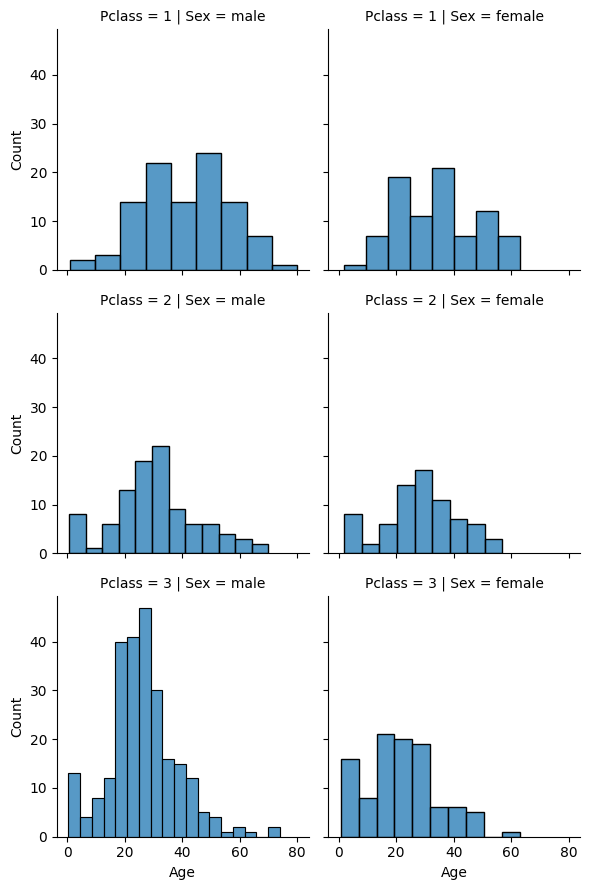

In [11]:
g = sns.FacetGrid(train_df, col='Sex', row='Pclass')
g.map(sns.histplot, 'Age');

So, we can see that most of the people are males and of class 3.

2. We will calculate the median of each subplot and use them to substitute null values of their corresponding distribution.


In [12]:
median_ages = np.zeros((2, 3))
median_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [13]:
# get median values for each sub df
for i, sex in enumerate(['female', 'male']):
    for pclass in range(1, 4):
        subset = train_df[(train_df['Age'].notna()) & (train_df['Sex'] == sex) & (train_df['Pclass'] == pclass)]['Age']
        median_ages[i, pclass - 1] =  subset.median()
median_ages

array([[35. , 28. , 21.5],
       [40. , 30. , 25. ]])

In [14]:
# substitute with the median_ages of the train subsets in both train_df and test_df
for df in [train_df, test_df]:
    for i, sex in enumerate(['female', 'male']):
        for pclass in range(1, 4):
            mask = (df['Age'].isna()) & (df['Sex'] == sex) & (df['Pclass'] == pclass)
            df.loc[mask, 'Age'] = median_ages[i, pclass - 1]


In [15]:
train_df['Age'].isna().sum()

0

In [16]:
test_df['Age'].isna().sum()

0

## 2.2 Handling Duplicated Values

Check for the whole dataset duplications.

In [17]:
train_df.duplicated().sum()

0

check for `Ticket` column duplications

In [18]:
train_df['Ticket'].duplicated().sum()

210

So, we can drop this column from our dataset

In [19]:
train_df.drop(columns='Ticket', inplace=True)
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [20]:
test_df.drop(columns='Ticket', inplace=True)
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S


# 3. Feature Engineering

In this section we will create a new features out of existing ones that may conatin high predictive power, so let's dive in!

In [21]:
# Let's breakdown first the Name column to extract titles, feel free to do this step by step at first
title_names = train_df['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]
title_names

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886      Rev
887     Miss
888     Miss
889       Mr
890       Mr
Name: 0, Length: 891, dtype: object

In [22]:
title_names.value_counts()

0
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [23]:
top_titles = title_names.value_counts().nlargest(4).index
top_titles

Index([' Mr', ' Miss', ' Mrs', ' Master'], dtype='object', name=0)

Note that these values contain unwanted spacing [' Mr', ' Miss', ' Mrs', ' Master'], so use the `strip()` method to remove it.


In [24]:
title_names.str.strip()

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: 0, Length: 891, dtype: object

In [25]:
def feature_engineering(df, train_split=True):
    """
    Perform feature engineering on the provided dataframe.

    Parameters:
    df: DataFrame
        The input dataframe, either the training or test set.
    train_split: bool
        Specifies whether the dataframe is a training set (True) or test set (False).
        This helps avoid data leakage by ensuring that bins for Age and Fare are derived from the training data only.

    Returns:
    DataFrame
        The modified dataframe with additional features.
    """
    
    # Family size variable: total family members including the individual
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # IsAlone variable: equals 1 if FamilySize is 1, else equals 0
    df['IsAlone'] = df['FamilySize'].map(lambda x: 1 if x == 1 else 0)
    
    # Extract titles from the Name column (e.g., Mr, Miss, Master)
    df['Title'] = df['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0].str.strip()
    
    # Define the top four titles for consistency
    top_titles = ['Mr', 'Miss', 'Mrs', 'Master']
    
    # Replace uncommon titles with more common equivalents
    df['Title'] = df['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})
    
    # Group titles that are not in the top four as 'Rare'
    df['Title'] = df['Title'].apply(lambda x: x if x in top_titles else 'Rare')
    
    # Drop the Name column as it is no longer needed
    df.drop(columns='Name', inplace=True)

    """
    qcut is used to divide the data into equal-sized bins (quantiles).
    Unlike cut, which divides data based on the range of values,
    qcut ensures each bin has the same number of observations.
    """
    
    if train_split:
        # Create 4 quantiles for the 'Fare' column
        df['FareBin'] = pd.qcut(df['Fare'], q=4)
        # Create 5 bins for the 'Age' column
        df['AgeBin'] = pd.cut(df['Age'].astype(int), bins=5)
    else:
        # Obtain bins from the training set to avoid leakage
        fare_bins = pd.qcut(train_df['Fare'], q=4, retbins=True)[1]
        age_bins = pd.cut(train_df['Age'].astype(int), bins=5, retbins=True)[1]  # Get bin edges
        
        # Assign the bins to the test dataframe based on the training bins
        df['FareBin'] = pd.cut(df['Fare'], bins=fare_bins, include_lowest=True)
        df['AgeBin'] = pd.cut(df['Age'].astype(int), bins=age_bins, include_lowest=True)
    
    # Encode the 'Sex' column: map female to 0 and male to 1
    df['Sex'] = df['Sex'].map(lambda x: 0 if x == 'female' else 1)
    
    return df


In [26]:
train_df = feature_engineering(train_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,1,0,3,1,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,2,1,1,0,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,3,1,3,0,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,4,1,1,0,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,5,0,3,1,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


In [27]:
test_df = feature_engineering(test_df, train_split=False)
test_df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,892,3,1,34.5,0,0,7.8292,Q,1,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
1,893,3,0,47.0,1,0,7.0000,S,2,0,Mrs,"(-0.001, 7.91]","(32.0, 48.0]"
2,894,2,1,62.0,0,0,9.6875,Q,1,1,Mr,"(7.91, 14.454]","(48.0, 64.0]"
3,895,3,1,27.0,0,0,8.6625,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
4,896,3,0,22.0,1,1,12.2875,S,3,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"


We shall check for inconsistencies, such as the occurrence of males with the title "Miss." We can use a pivot table combined with additional filtering to identify any such mismatches.


In [28]:
pivot_table = train_df.pivot_table(index='Title', columns='Sex', aggfunc='size', fill_value=0)
pivot_table

Sex,0,1
Title,,
Master,0,40
Miss,185,0
Mr,0,517
Mrs,126,0
Rare,3,20


Great! Let's continue..

# 4. EDA & Feature Selection

In [29]:
train_df[['FamilySize', 'Survived']] \
    .groupby('FamilySize') \
    .mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
FamilySize,
4,0.724138
3,0.578431
2,0.552795
7,0.333333
1,0.303538
5,0.200000
6,0.136364
8,0.000000
11,0.000000


In [30]:
train_df[['IsAlone', 'Survived']] \
    .groupby('IsAlone') \
    .mean() \
    .sort_values(by = 'Survived', ascending=False)

,Survived
IsAlone,
0,0.505650
1,0.303538


So, we can see that around 50% of people with their families survived, while only 30% of those who are alone survived. Then, we can select the IsAlone feature and drop [Parch, SibSp, FamilySize].


In [31]:
train_df.drop(columns=['Parch', 'SibSp', 'FamilySize'], inplace=True)
test_df.drop(columns=['Parch', 'SibSp', 'FamilySize'], inplace=True)

In [32]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title,FareBin,AgeBin
0,1,0,3,1,22.0,7.2500,S,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,2,1,1,0,38.0,71.2833,C,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,3,1,3,0,26.0,7.9250,S,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,4,1,1,0,35.0,53.1000,S,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,5,0,3,1,35.0,8.0500,S,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


In [33]:
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,IsAlone,Title,FareBin,AgeBin
0,892,3,1,34.5,7.8292,Q,1,Mr,"(-0.001, 7.91]","(32.0, 48.0]"
1,893,3,0,47.0,7.0000,S,0,Mrs,"(-0.001, 7.91]","(32.0, 48.0]"
2,894,2,1,62.0,9.6875,Q,1,Mr,"(7.91, 14.454]","(48.0, 64.0]"
3,895,3,1,27.0,8.6625,S,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
4,896,3,0,22.0,12.2875,S,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"


In [34]:
train_df[['AgeBin', 'Survived']] \
    .groupby('AgeBin') \
    .mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
AgeBin,
"(-0.08, 16.0]",0.550000
"(48.0, 64.0]",0.434783
"(32.0, 48.0]",0.412037
"(16.0, 32.0]",0.337374
"(64.0, 80.0]",0.090909


Let's replace the AgeBin with an ordinal encoder based on these bands.


In [35]:
pd.Interval(0, 1)

Interval(0, 1, closed='right')

In [36]:
import pandas as pd

def encode_age_column(df):
    # Define the function to categorize ages
    def categorize_age(age):
        if age in pd.Interval(-0.08, 16.0):
            return 5
        elif age in pd.Interval(16.0, 32.0):
            return 2
        elif age in pd.Interval(32.0, 48.0):
            return 3
        elif age in pd.Interval(48.0, 64.0):
            return 4
        elif age in pd.Interval(64.0, float('inf')):
            return 1
        else:
            return None 

    df['AgeCategory'] = df['Age'].apply(categorize_age)
    
    # Drop original 'Age' and 'AgeBin' columns
    df.drop(columns=['Age', 'AgeBin'], inplace=True)
    
    return df


In [37]:
train_df = encode_age_column(train_df)
train_df.head()

,PassengerId,Survived,Pclass,Sex,Fare,Embarked,IsAlone,Title,FareBin,AgeCategory
0,1,0,3,1,7.2500,S,0,Mr,"(-0.001, 7.91]",2
1,2,1,1,0,71.2833,C,0,Mrs,"(31.0, 512.329]",3
2,3,1,3,0,7.9250,S,1,Miss,"(7.91, 14.454]",2
3,4,1,1,0,53.1000,S,0,Mrs,"(31.0, 512.329]",3
4,5,0,3,1,8.0500,S,1,Mr,"(7.91, 14.454]",3


In [38]:
test_df = encode_age_column(test_df)
test_df.head()

,PassengerId,Pclass,Sex,Fare,Embarked,IsAlone,Title,FareBin,AgeCategory
0,892,3,1,7.8292,Q,1,Mr,"(-0.001, 7.91]",3
1,893,3,0,7.0000,S,0,Mrs,"(-0.001, 7.91]",3
2,894,2,1,9.6875,Q,1,Mr,"(7.91, 14.454]",4
3,895,3,1,8.6625,S,1,Mr,"(7.91, 14.454]",2
4,896,3,0,12.2875,S,0,Mrs,"(7.91, 14.454]",2


In [39]:
test_df.isna().sum()

PassengerId    0
Pclass         0
Sex            0
Fare           0
Embarked       0
IsAlone        0
Title          0
FareBin        0
AgeCategory    0
dtype: int64

Now, Let's explore `Embarked Variable` before encoding it


In [40]:
train_df[['Embarked', 'Survived']].groupby('Embarked')\
    .mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.339009


We will use one hot encoder here as it preserves the information about the categories without imposing any ordinal relationships

In [41]:
one_hot_encoder = OneHotEncoder(cols='Embarked', use_cat_names=True)

target = train_df[['Survived']]

train_df_without_target = one_hot_encoder.fit_transform(train_df.drop(columns='Survived'))
test_df = one_hot_encoder.transform(test_df)

train_df = pd.concat([train_df_without_target, target], axis=1)

In [42]:
train_df.head()

,PassengerId,Pclass,Sex,Fare,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,FareBin,AgeCategory,Survived
0,1,3,1,7.2500,1,0,0,0,Mr,"(-0.001, 7.91]",2,0
1,2,1,0,71.2833,0,1,0,0,Mrs,"(31.0, 512.329]",3,1
2,3,3,0,7.9250,1,0,0,1,Miss,"(7.91, 14.454]",2,1
3,4,1,0,53.1000,1,0,0,0,Mrs,"(31.0, 512.329]",3,1
4,5,3,1,8.0500,1,0,0,1,Mr,"(7.91, 14.454]",3,0


In [43]:
test_df.head()

,PassengerId,Pclass,Sex,Fare,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,FareBin,AgeCategory
0,892,3,1,7.8292,0,0,1,1,Mr,"(-0.001, 7.91]",3
1,893,3,0,7.0000,1,0,0,0,Mrs,"(-0.001, 7.91]",3
2,894,2,1,9.6875,0,0,1,1,Mr,"(7.91, 14.454]",4
3,895,3,1,8.6625,1,0,0,1,Mr,"(7.91, 14.454]",2
4,896,3,0,12.2875,1,0,0,0,Mrs,"(7.91, 14.454]",2


In [44]:
train_df[['FareBin', 'Survived']].groupby('FareBin').mean().sort_values(by='Survived', ascending=False)

,Survived
FareBin,
"(31.0, 512.329]",0.581081
"(14.454, 31.0]",0.454955
"(7.91, 14.454]",0.303571
"(-0.001, 7.91]",0.197309


It seems that the people who paid more have a higher probability of survival. We will convert the Fare feature to ordinal values based on FareBin.


In [45]:
def encode_fare_column(df):

    def categorize_fare(fare):
        if fare in pd.Interval(31.0, float('inf')):
            return 4
        elif fare in pd.Interval(14.454, 31.0):
            return 3
        elif fare in pd.Interval(7.91, 14.454):
            return 2
        elif fare in pd.Interval(-0.001, 7.91):
            return 1
        else:
            return None 

    df['FareCategory'] = df['Fare'].apply(categorize_fare)
    
    df.drop(columns=['Fare', 'FareBin'], inplace=True)
    
    return df


In [46]:
train_df = encode_fare_column(train_df)
train_df.head()

,PassengerId,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,Survived,FareCategory
0,1,3,1,1,0,0,0,Mr,2,0,1
1,2,1,0,0,1,0,0,Mrs,3,1,4
2,3,3,0,1,0,0,1,Miss,2,1,2
3,4,1,0,1,0,0,0,Mrs,3,1,4
4,5,3,1,1,0,0,1,Mr,3,0,2


In [47]:
train_df.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Embarked_S      0
Embarked_C      0
Embarked_Q      0
IsAlone         0
Title           0
AgeCategory     0
Survived        0
FareCategory    0
dtype: int64

In [48]:
test_df = encode_fare_column(test_df)
test_df.head()

,PassengerId,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,FareCategory
0,892,3,1,0,0,1,1,Mr,3,1
1,893,3,0,1,0,0,0,Mrs,3,1
2,894,2,1,0,0,1,1,Mr,4,2
3,895,3,1,1,0,0,1,Mr,2,2
4,896,3,0,1,0,0,0,Mrs,2,2


In [49]:
test_df.isna().sum()

PassengerId     0
Pclass          0
Sex             0
Embarked_S      0
Embarked_C      0
Embarked_Q      0
IsAlone         0
Title           0
AgeCategory     0
FareCategory    0
dtype: int64

Let's check Title column values

In [50]:
train_df[['Title', 'Survived']] \
    .groupby('Title') \
    .mean() \
    .sort_values(by='Survived', ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575000
Rare,0.347826
Mr,0.156673


In [51]:
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [52]:
ordinal_encoder = OrdinalEncoder(categories=[['Master', 'Miss', 'Mrs', 'Mr', 'Rare']])

train_df['Title'] = ordinal_encoder.fit_transform(train_df[['Title']])
test_df['Title'] = ordinal_encoder.transform(test_df[['Title']])

In [53]:
train_df.head()

,PassengerId,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,Survived,FareCategory
0,1,3,1,1,0,0,0,3.0,2,0,1
1,2,1,0,0,1,0,0,2.0,3,1,4
2,3,3,0,1,0,0,1,1.0,2,1,2
3,4,1,0,1,0,0,0,2.0,3,1,4
4,5,3,1,1,0,0,1,3.0,3,0,2


In [54]:
test_df.head()

,PassengerId,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,FareCategory
0,892,3,1,0,0,1,1,3.0,3,1
1,893,3,0,1,0,0,0,2.0,3,1
2,894,2,1,0,0,1,1,3.0,4,2
3,895,3,1,1,0,0,1,3.0,2,2
4,896,3,0,1,0,0,0,2.0,2,2


In [55]:
train_df.drop(columns='PassengerId', inplace=True)
train_df.head()

,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,Survived,FareCategory
0,3,1,1,0,0,0,3.0,2,0,1
1,1,0,0,1,0,0,2.0,3,1,4
2,3,0,1,0,0,1,1.0,2,1,2
3,1,0,1,0,0,0,2.0,3,1,4
4,3,1,1,0,0,1,3.0,3,0,2


<Axes: >

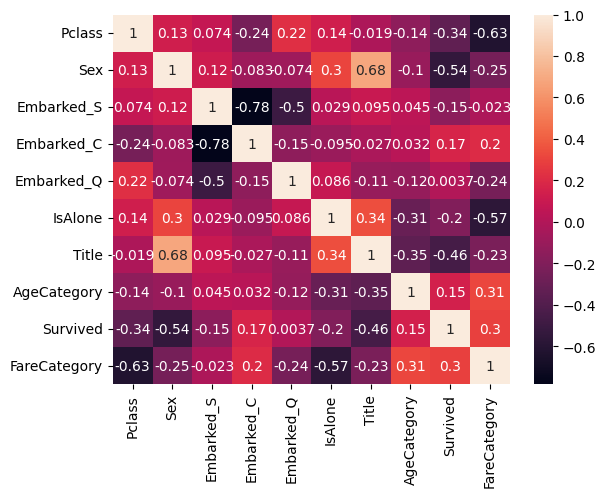

In [56]:
sns.heatmap(train_df.corr(), annot=True)

We can see that Sex and Title are the most correlated features with our target variable.

In [57]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

The data is not balanced, so we cannot rely on the accuracy metric here. Therefore, we will examine the confusion matrix for more information.


# 5. Splitting Data into train and validation sets




In [58]:
target = 'Survived'

X = train_df.drop(columns=target)
y = train_df[target]

print(f'X shape = {X.shape}, y shape = {y.shape}')

X shape = (891, 9), y shape = (891,)


In [59]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape = {X_train.shape}')
print(f'X_val shape = {X_val.shape}')
print(f'y_train shape = {y_train.shape}')
print(f'y_val shape = {y_val.shape}')


X_train shape = (712, 9)
X_val shape = (179, 9)
y_train shape = (712,)
y_val shape = (179,)


In [60]:
X_test = test_df.drop(columns='PassengerId')
X_test.head()

,Pclass,Sex,Embarked_S,Embarked_C,Embarked_Q,IsAlone,Title,AgeCategory,FareCategory
0,3,1,0,0,1,1,3.0,3,1
1,3,0,1,0,0,0,2.0,3,1
2,2,1,0,0,1,1,3.0,4,2
3,3,1,1,0,0,1,3.0,2,2
4,3,0,1,0,0,0,2.0,2,2


# 6. Modeling

In [61]:
def try_different_models(models):
    results = {}

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        results[model_name] = {
            'train_acc': accuracy_score(y_train, y_train_pred),
            'val_acc': accuracy_score(y_val, y_val_pred),
            'train_recall': recall_score(y_train, y_train_pred),
            'val_recall': recall_score(y_val, y_val_pred),
            'train_precision': precision_score(y_train, y_train_pred),
            'val_precision': precision_score(y_val, y_val_pred),
            'train_f1_score': f1_score(y_train, y_train_pred),
            'val_f1_score': f1_score(y_val, y_val_pred)
        }

        print(f'{model_name} has finished.')

    
    result_df = pd.DataFrame(results).T
    return result_df, models

In [62]:
models = {
    'Logistic Regression': LogisticRegression(),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Naive Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier()
}

results_df, _ = try_different_models(models)
results_df.sort_values(by='val_f1_score', ascending=False)

Logistic Regression has finished.
XGBoost has finished.
SVM has finished.
Decision Tree has finished.
Random Forest has finished.
Naive Bayes has finished.
KNN has finished.


,train_acc,val_acc,train_recall,val_recall,train_precision,val_precision,train_f1_score,val_f1_score
XGBoost,0.870787,0.821229,0.783582,0.810811,0.860656,0.769231,0.820312,0.789474
Decision Tree,0.870787,0.815642,0.772388,0.810811,0.869748,0.759494,0.818182,0.784314
Random Forest,0.870787,0.810056,0.783582,0.770270,0.860656,0.770270,0.820312,0.770270
KNN,0.845506,0.810056,0.757463,0.770270,0.818548,0.770270,0.786822,0.770270
Naive Bayes,0.776685,0.782123,0.783582,0.837838,0.675241,0.696629,0.725389,0.760736
Logistic Regression,0.794944,0.798883,0.705224,0.770270,0.738281,0.750000,0.721374,0.760000
SVM,0.823034,0.793296,0.723881,0.702703,0.788618,0.776119,0.754864,0.737589


We will continue with the best 4 models of validation f1 score.

# 7. Hyperparameter Tuning

In [63]:
def get_best_hyperparameters_using_grid_search(model, param_grid):
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
        
    grid.fit(X, y)
    
    return grid.best_params_
    

## 7.1 Decision Tree Hyperparameter Tuning

In [64]:
dt_model = DecisionTreeClassifier()
dt_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 50),
}

best_dt_param = get_best_hyperparameters_using_grid_search(dt_model, dt_param)
best_dt_param

{'criterion': 'entropy', 'max_depth': 3}

# 7.2 Random Forest Hyperparameter Tuning

In [65]:
rf_model = RandomForestClassifier()
rf_param = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 5]
}

best_rf_param = get_best_hyperparameters_using_grid_search(rf_model, rf_param)
best_rf_param

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

## 7.3 XGBoost Hyperparameter Tuning

In [66]:
xgb_model = XGBClassifier()

xgb_param = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0]
}

best_xgb_param = get_best_hyperparameters_using_grid_search(xgb_model, xgb_param)
best_xgb_param

{'classifier__colsample_bytree': 0.8,
 'classifier__learning_rate': 0.01,
 'classifier__max_depth': 3,
 'classifier__n_estimators': 100,
 'classifier__subsample': 0.8}

In [67]:
models = {
    'XGBoost': XGBClassifier(**best_xgb_param, random_state=42),
    'Decision Tree': DecisionTreeClassifier(**best_dt_param, random_state=42),
    'Random Forest': RandomForestClassifier(**best_rf_param, random_state=42),
    'KNN': KNeighborsClassifier()
}

results_df, models = try_different_models(models)
results_df

XGBoost has finished.
Decision Tree has finished.
Random Forest has finished.
KNN has finished.


,train_acc,val_acc,train_recall,val_recall,train_precision,val_precision,train_f1_score,val_f1_score
XGBoost,0.870787,0.821229,0.783582,0.810811,0.860656,0.769231,0.820312,0.789474
Decision Tree,0.816011,0.798883,0.727612,0.743243,0.770751,0.763889,0.748560,0.753425
Random Forest,0.832865,0.782123,0.686567,0.675676,0.840183,0.769231,0.755647,0.719424
KNN,0.845506,0.810056,0.757463,0.770270,0.818548,0.770270,0.786822,0.770270


In [68]:
for col in results_df.columns:
    best_model = results_df[col].idxmax()
    print(f'{best_model} is the best model according to {col} column.')

XGBoost is the best model according to train_acc column.
XGBoost is the best model according to val_acc column.
XGBoost is the best model according to train_recall column.
XGBoost is the best model according to val_recall column.
XGBoost is the best model according to train_precision column.
KNN is the best model according to val_precision column.
XGBoost is the best model according to train_f1_score column.
XGBoost is the best model according to val_f1_score column.


In [69]:
def plot_feature_importances(model):
    importances = model.feature_importances_
    features = model.feature_names_in_
    
    feat_imp = pd.Series(importances, index=features).sort_values(ascending=True)
    feat_imp.plot.barh()
    plt.show()

XGBoost feature importances:


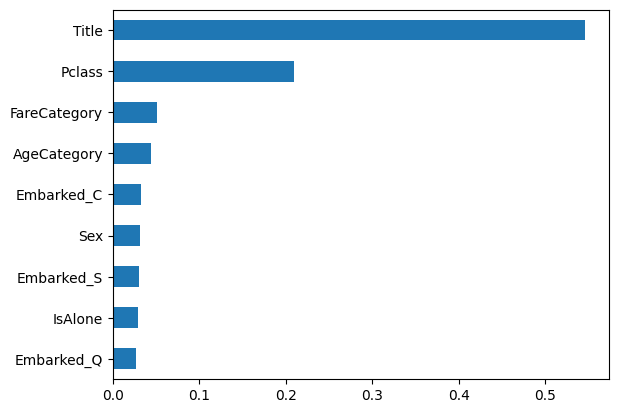

Decision Tree feature importances:


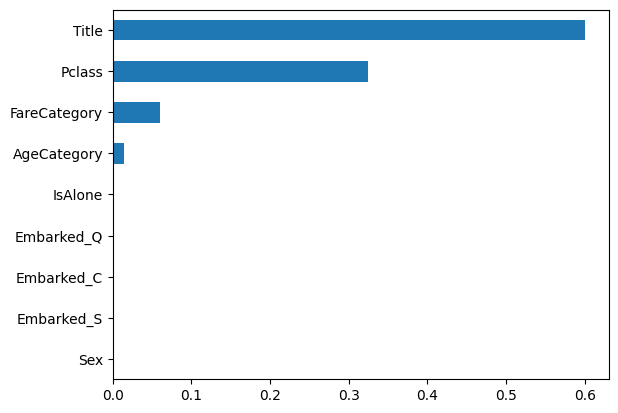

Random Forest feature importances:


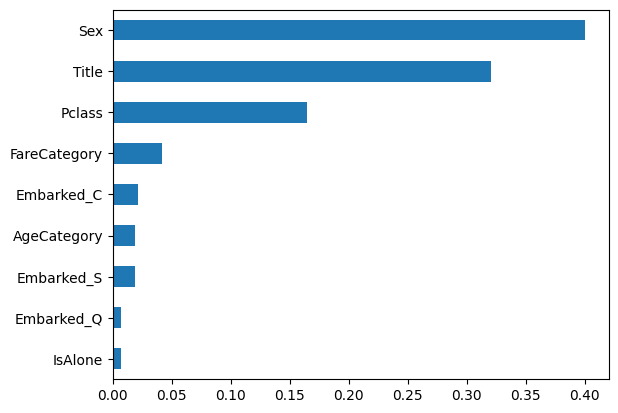

In [70]:
for model_name, model in models.items():
    if model_name != 'KNN':
        print(f'{model_name} feature importances:')
        plot_feature_importances(model)

# 8. Submissions

In [71]:
templete = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
templete

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [72]:
def save_submission_df(model_name, model):
    model.fit(X, y)
    y_pred = model.predict(X_test)
    
    submission_df = pd.DataFrame(data = {
        'PassengerId': test_df['PassengerId'],
        'Survived': y_pred
    })
    
    submission_df.to_csv(f'{model_name} Submission.csv', index=False)
    

In [73]:
for model_name, model in models.items():
    save_submission_df(model_name, model)